## load 参数

In [156]:
import numpy as np
import cv2
import scipy.io as scio

Params=scio.loadmat('workspace.mat')
K = np.array(Params['K'])
K = K.T
distortion=np.array(Params['distortion'])

## sift特征匹配

In [157]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgpath = 'images/'
MIN_MATCH_COUNT = 10

def match_pts(imgname1, imgname2):
    img1 = cv2.imread(imgpath+imgname1, 0)          # queryImage
    img2 = cv2.imread(imgpath+imgname2, 0)        # trainImage

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    pts1 = []
    pts2 = []
    
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    # return the np.array type
    return pts1, pts2

# estimate估计参数

In [158]:
from numpy import *
from scipy import *
from scipy.linalg import *
from pylab import *
import cv2
import sys

def find_fundamental(pts1, pts2):
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
    return F
    
def find_essential(F, K1, K2):
    return K2.T @ F @ K1

def skew(a):
    #Skew matrix A such that cross(a,v) = Av for any v
    return array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def anti_skew(A):
    return array([A[2,1], A[2,0], A[1,0]])

def triangulate(P1, P2, pts1, pts2):
    n1 = pts1.shape[0]
    n2 = pts2.shape[0]
    
    p1 = vstack([ pts1.T, ones(n1) ]).T
    p2 = vstack([ pts2.T, ones(n2) ]).T
    
    P = zeros((n1, 4))
    for i in range(n1):
        cross1 = skew(p1[i])
        cross2 = skew(p2[i])
        Q = vstack([cross1 @ P1, cross2 @ P2])
        U,S,VT = svd(Q)
        z = VT[-1, :]
        P[i, :] = z/z[3]
    
    return P[:, 0:3]

def guess_rotation(E):
    # make sure E is rank 2
    U,S,V = svd(E)
    if det(dot(U,V)) < 0:
        V = -V
    E = dot(U,dot(diag([1,1,0]),V))    

    W = array([[0,-1,0],[1,0,0],[0,0,1]])
        
    R21 = dot(U,dot(W,V))
    R22 = dot(U,dot(W.T,V))
    
    T21 = anti_skew(E @ R21.T) 
    T22 = anti_skew(E @ R22.T)
    
    return R21, T21, R22, T22

def test_rotation(P1, P2, pts1, pts2):
    #temp = cv2.triangulatePoints(P1, P2, transpose(pts1), transpose(pts2))
    temp = triangulate(P1, P2, pts1, pts2)
    for v in temp:
        if v[-1] < 0:
            return False
    return True
    

def find_rotation(E, K1, K2, pts1, pts2):
    R1 = eye(3)
    T1 = array([0, 0, 0])
    P1 = K1 @ vstack([R1.T, T1]).T
    
    R21, T21, R22, T22 = guess_rotation(E)
    
    P21 = K2 @ vstack([R21.T, T21]).T
    P22 = K2 @ vstack([R22.T, T22]).T

    key1 = test_rotation(P1, P21, pts1, pts2)
    key2 = test_rotation(P1, P22, pts1, pts2)
    
    R2 = R21
    T2 = T21

    if key1:
        R2 = R21
        T2 = T21
    elif key2 or True:
        R2 = R22
        T2 = T22
    else:
        print('Can not find the right R matrix.')
        sys.exit()

    return R1, T1, R2, T2
    
def find_pose(R1, T1, R2, T2, K1, K2):
    #return K @ vstack([R.T, T]).T
    P1 = K1 @ vstack([R1.T, T1]).T
    P2 = K2 @ vstack([R2.T, T2]).T
    
    return P1, P2


## 运行

In [159]:
pts1, pts2 = match_pts('1_.jpg', '2_.jpg')
print(pts1.shape)

F = find_fundamental(pts1, pts2)
E = find_essential(F, K, K)
print('ok')

R1, T1, R2, T2 = find_rotation(E, K, K, pts1, pts2)
print('ok')

(1340, 2)
ok
ok


In [160]:
print(R1, T1, R2, T2, sep='\n')
K1 = K
K2 = K
P1, P2 = find_pose(R1, T1, R2, T2, K1, K2)
points = triangulate(P1, P2, pts1, pts2)
print(points)
points = np.array(points).astype(str)

f=open("reconstruction.txt","w")
for i in range(points.shape[0]):
    print(i)
    f.write(points[i][0]+','+points[i][1]+','+points[i][2]+'\n')
f.close()

#print('the space points:', points[500:510], points[300:310], sep ='\n---------\n')

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0 0 0]
[[ 0.99680378 -0.01337628  0.07876103]
 [ 0.01358739  0.99990539 -0.00214501]
 [-0.07872489  0.00320831  0.99689122]]
[-0.9751416   0.00491469  0.22152812]
[[ 1.08730559  0.23607783 -0.06398924]
 [ 1.26596994  0.37534458 -0.26630398]
 [-5.11775378  4.58121831 13.22038436]
 ...
 [ 0.87550716 -0.10425342  0.20811688]
 [ 0.86184719 -0.14058116  0.25745897]
 [-0.22490289 -0.1088158  -1.59844748]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
1

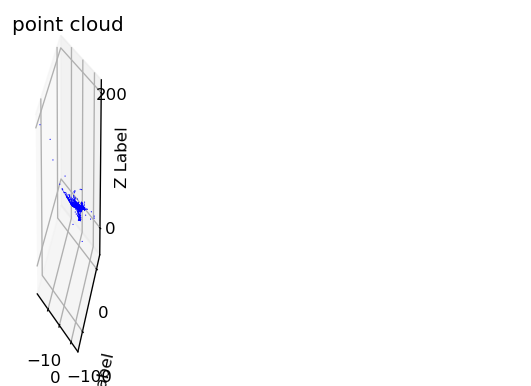

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#打开点云数据文件
f=open('reconstruction.txt','r')
point=f.read()
f.close()
#数据预处理
l1=point.replace('\n',',')
#将数据以“，”进行分割
l2=l1.split(',')
l2.pop()
#print(l2)
#将数据转为矩阵
m1=np.array(l2)
#print(m1)
#变形
m2=m1.reshape(int(m1.shape[0]/3),3)
#print(m2)
m3=[]
for each in m2:
	each_line=list(map(lambda x:float(x),each))
	m3.append(each_line)
    
for i in range (len(m3)):
    if i==len(m3)-1:
        break
    if m3[i][2]<0 or m3[i][2]>50 or m3[i][0]<(-50) or m3[i][0]>50 or m3[i][1]<(-50) or m3[i][1]>50:
        del(m3[i])
 
    
m4=np.array(m3)

#列表解析x,y,z的坐标
x=[k[0] for k in m4]
y=[k[1] for k in m4]
z=[k[2] for k in m4]

#开始绘图
fig=plt.figure(dpi=120)
ax=fig.add_subplot(111,projection='3d')
#标题
plt.title('point cloud')
#利用xyz的值，生成每个点的相应坐标（x,y,z）
ax.scatter(x,y,z,c='b',marker='.',s=2,linewidth=0,alpha=1,cmap='spectral')
ax.axis('scaled')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#显示
plt.show()

## MVS多图

In [161]:
def stereoAndTranslation(imgname1, imgname2):
    pts1, pts2 = match_pts(imgname1, imgname2)

    F = find_fundamental(pts1, pts2)
    E = find_essential(F, K, K)
    R1, T1, R2, T2 = find_rotation(E, K, K, pts1, pts2)
    
    R = R2
    T = T2
    return X, R, T